# Model Elastic Moduli From Soil Moisture
Let's start from the coherent media, which has the following essential components:
- Solid rock matrix
- Porosity
- Saturating fluids

These components determine the effective elastic moduli, thus predicting the velocity of P and S waves

In [154]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_dir='/fd1/QibinShi_data/England_farm/'

## 1. Formula from Solazzi et al. (2021)
Contact model is typical for porous rock media. 

As porosity increases, the contact number will decrease. 

The contacts may slip under stress. 

Therefore, we have 2 more parameters. The totally 4 parameters are:

- Porosity (fraction of volume as fluids)
- Moisture (fraction of volume as water)
- Coordinate number N (contacts per grain)
- Non-slip fraction f (fraction of contacts)

<img src="./rock_structure.png" alt="porous rock media" width="300">

In [162]:
class litho:
    def __init__(self, bulk_density, porosity, N, f, s):
        self.rho_d = bulk_density
        self.phi = porosity  ## derived from K_d, actually
        self.N = N
        self.f = f
        self.s = s  ## Saturation

        ## Solid grains
        self.rho_s = 2650 # kg/m^3
        self.K_s = 37e9 # Pa
        self.G_s = 44e9 # Pa

        ## Water
        self.rho_w = 1000
        self.K_w = 2.2e9  ## by Copilot

        ## Air
        self.rho_a = 1.2  ## kg/m^3
        self.K_a = 1e5  ## by Copilot

        ## Poisson's ratio 
        nu = (3*self.K_s-2*self.G_s)/(2*(3*self.K_s+self.G_s))

        ## Partially saturated soil (Biot-Gassmann)
        self.K_f = 1 / (self.s / self.K_w  +  (1-self.s) / self.K_a)
        self.rho = (1-self.phi)*self.rho_s + self.phi*(self.s*self.rho_w + (1-self.s)*self.rho_a)

        ## Moduli of drained soil (Hertz-Mindlin)
        P_e = (self.rho - self.rho_a) * 9.8 * 0.1
        self.K_d = (N**2 * (1-self.phi)**2 * self.G_s**2 / (18*np.pi**2 * (1-nu)**2) * P_e)**(1/3)
        self.G_d = 3 * self.K_d * (2+3*f-(1+3*f)*nu) / (2 - nu) / 5

    
    def get_vp_vs(self):
        
        self.K = self.K_d + (1-self.K_d/self.K_s)**2 / (self.phi/self.K_f + (1-self.phi)/self.K_s - self.K_d/self.K_s**2)
        self.G = self.G_d

        self.vp = np.sqrt((self.K + 4*self.G/3)/self.rho)
        self.vs = np.sqrt(self.G/self.rho)

        return self.vp, self.vs, self.K, self.G, self.rho
    


## 2. Load porosity data of drained samples

In [156]:
phy_paras = pd.read_csv(data_dir + 'Soil_phy.csv')

phy_1 = phy_paras.loc[phy_paras['Plot'].between(1,9)]
phy_2 = phy_paras.loc[phy_paras['Plot'].between(10,18)]
phy_3 = phy_paras.loc[phy_paras['Plot'].between(19,27)]

phy_1['ind'] = 36 - phy_1['Plot'] 
phy_2['ind'] = 33 - phy_2['Plot']
phy_3['ind'] = 30 - phy_3['Plot']

phy_all = pd.concat([phy_1, phy_2, phy_3])
phy_10cm = phy_all.loc[phy_all['Depth (cm)'] == 10]
phy_20cm = phy_all.loc[phy_all['Depth (cm)'] == 20]
phy_30cm = phy_all.loc[phy_all['Depth (cm)'] == 30]

<ipython-input-156-dd0ca59cd14b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phy_1['ind'] = 36 - phy_1['Plot']
<ipython-input-156-dd0ca59cd14b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phy_2['ind'] = 33 - phy_2['Plot']
<ipython-input-156-dd0ca59cd14b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

### Bulk density at different depths

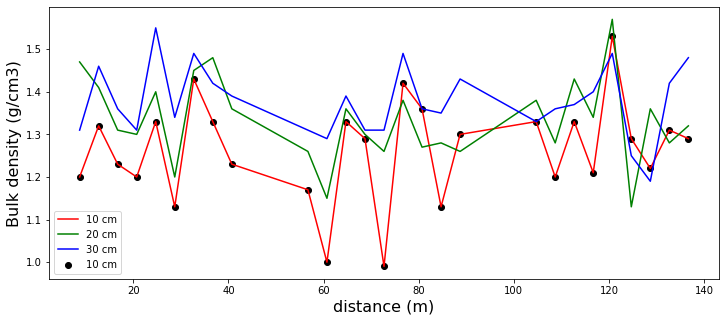

In [4]:
plt.figure(figsize=(12, 5))
plt.scatter(np.array(phy_10cm['ind'])*4-3.3, np.array(phy_10cm['Dry Bulk density (g/cm3)']), label='10 cm', color='k')
plt.plot(np.array(phy_10cm['ind'])*4-3.3, np.array(phy_10cm['Dry Bulk density (g/cm3)']), label='10 cm', color='r')
plt.plot(np.array(phy_20cm['ind'])*4-3.3, np.array(phy_20cm['Dry Bulk density (g/cm3)']), label='20 cm', color='g')
plt.plot(np.array(phy_30cm['ind'])*4-3.3, np.array(phy_30cm['Dry Bulk density (g/cm3)']), label='30 cm', color='b')

plt.xlabel("distance (m)", fontsize = 16)
plt.ylabel("Bulk density (g/cm3)", fontsize = 16)
plt.legend()

### Porosity at different depths (inversely proportional to bulk density)

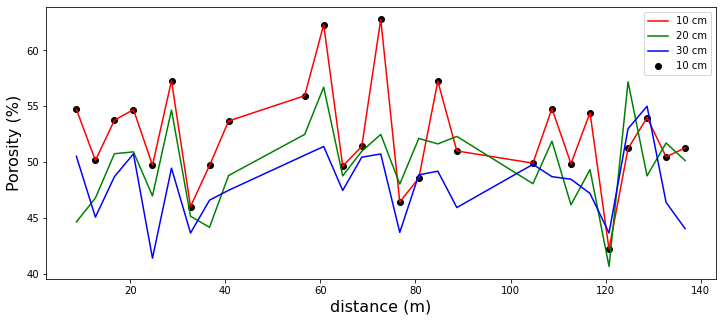

In [5]:
plt.figure(figsize=(12, 5))
plt.scatter(np.array(phy_10cm['ind'])*4-3.3, np.array(phy_10cm['Porosity (%)']), label='10 cm', color='k')
plt.plot(np.array(phy_10cm['ind'])*4-3.3, np.array(phy_10cm['Porosity (%)']), label='10 cm', color='r')
plt.plot(np.array(phy_20cm['ind'])*4-3.3, np.array(phy_20cm['Porosity (%)']), label='20 cm', color='g')
plt.plot(np.array(phy_30cm['ind'])*4-3.3, np.array(phy_30cm['Porosity (%)']), label='30 cm', color='b')

plt.xlabel("distance (m)", fontsize = 16)
plt.ylabel("Porosity (%)", fontsize = 16)
plt.legend()

## 3. Load dV/V data for comparison

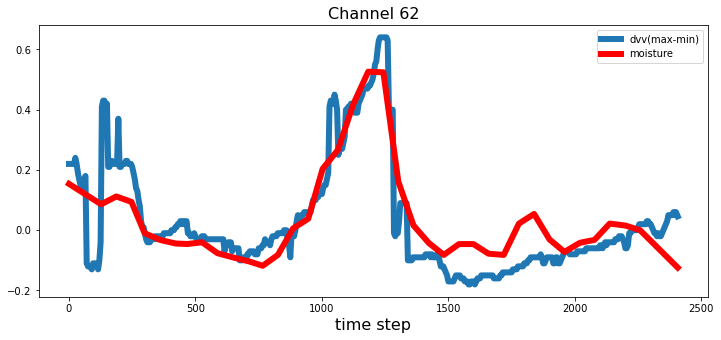

In [158]:
with h5py.File('/fd1/QibinShi_data/England_farm/interp_dvv_temp_moisture.hdf5', 'r') as f:
    moisture = f['moisture'][:]
    dvv = f['dvv'][18]
    
plt.figure(figsize=(12, 5))
plt.plot(np.arange(len(dvv)), dvv-1, label='dvv(max-min)', lw=6)
plt.plot(np.arange(len(moisture)), (90-moisture)/50, label='moisture', color='r', lw=6)

plt.xlabel("time step", fontsize = 16)
plt.title("Channel 62", fontsize = 16)
plt.legend()

## 4. Compare predicted Vs and measured V
#### Find the drained porosity near the channel of dV/V data

In [160]:
phy_10cm_ch62 = phy_10cm.loc[phy_10cm['ind'] == int((3.19 * 12 + 3.3) / 4 )]

bulk_density = phy_10cm_ch62['Dry Bulk density (g/cm3)'].values[0] * 1000
porosity = phy_10cm_ch62['Porosity (%)'].values[0] / 100

phy_10cm_ch62

,Plot,Treatments,tillage,Depth (cm),Dry Bulk density (g/cm3),Porosity (%),Moisture content (%),Rock volume (%),ind
57,20,STP Zero,0,10,1.33,49.7,15.28,0.67,10


### First, consider the case of partially saturation
Porosity does not change

In [163]:
sand1 = litho(bulk_density, porosity, 6, 0.0, moisture/100)
sand2 = litho(bulk_density, porosity, 6, 0.1, moisture/100)
sand3 = litho(bulk_density, porosity, 6, 0.2, moisture/100)
sand4 = litho(bulk_density, porosity, 6, 0.3, moisture/100)
clay1 = litho(bulk_density, porosity, 8, 0.0, moisture/100)
clay2 = litho(bulk_density, porosity, 8, 0.1, moisture/100)
clay3 = litho(bulk_density, porosity, 8, 0.2, moisture/100)
clay4 = litho(bulk_density, porosity, 8, 0.3, moisture/100)

In [164]:
vp_sand1, vs_sand1, K_sand1, G_sand1, rho_sand1 = sand1.get_vp_vs()
vp_sand2, vs_sand2, K_sand2, G_sand2, rho_sand2 = sand2.get_vp_vs()
vp_sand3, vs_sand3, K_sand3, G_sand3, rho_sand3 = sand3.get_vp_vs()
vp_sand4, vs_sand4, K_sand4, G_sand4, rho_sand4 = sand4.get_vp_vs()
vp_clay1, vs_clay1, K_clay1, G_clay1, rho_clay1 = clay1.get_vp_vs()
vp_clay2, vs_clay2, K_clay2, G_clay2, rho_clay2 = clay2.get_vp_vs()
vp_clay3, vs_clay3, K_clay3, G_clay3, rho_clay3 = clay3.get_vp_vs()
vp_clay4, vs_clay4, K_clay4, G_clay4, rho_clay4 = clay4.get_vp_vs()


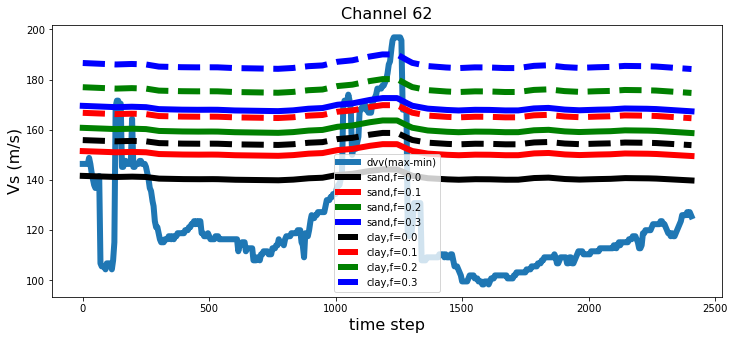

In [206]:
plt.figure(figsize=(12, 5))
plt.plot(np.arange(len(dvv)), dvv*120, label='dvv(max-min)', lw=6)
plt.plot(np.arange(len(moisture)), vs_sand1, label='sand,f=0.0', color='k', lw=6)
plt.plot(np.arange(len(moisture)), vs_sand2, label='sand,f=0.1', color='r', lw=6)
plt.plot(np.arange(len(moisture)), vs_sand3, label='sand,f=0.2', color='g', lw=6)
plt.plot(np.arange(len(moisture)), vs_sand4, label='sand,f=0.3', color='b', lw=6)
plt.plot(np.arange(len(moisture)), vs_clay1, label='clay,f=0.0', color='k', lw=6, ls='--')
plt.plot(np.arange(len(moisture)), vs_clay2, label='clay,f=0.1', color='r', lw=6, ls='--')
plt.plot(np.arange(len(moisture)), vs_clay3, label='clay,f=0.2', color='g', lw=6, ls='--')
plt.plot(np.arange(len(moisture)), vs_clay4, label='clay,f=0.3', color='b', lw=6, ls='--')

plt.xlabel("time step", fontsize = 16)
plt.ylabel("Vs (m/s)", fontsize = 16)
plt.title("Channel 62", fontsize = 16)
plt.legend()

What if it is saturated when moisture is extremely high

The porosity should linearly increase with the moisture (need reading)

The non-slip fraction could also decrease linearly with moisture

Let's experiment with a changing porosity.

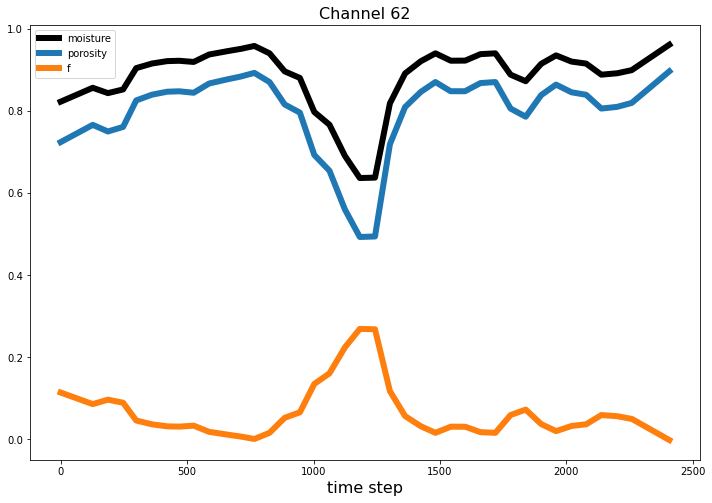

In [253]:
scale_factor = moisture/100 * 2.5 - 0.6

new_porosity = porosity * scale_factor
new_f = 0.6-scale_factor/3

plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(moisture)), moisture/100, label='moisture', color='k', lw=6)
plt.plot(np.arange(len(new_porosity)), new_porosity, label='porosity', lw=6)
plt.plot(np.arange(len(new_f)), new_f, label='f', lw=6)


plt.xlabel("time step", fontsize = 16)
plt.title("Channel 62", fontsize = 16) 
plt.legend()

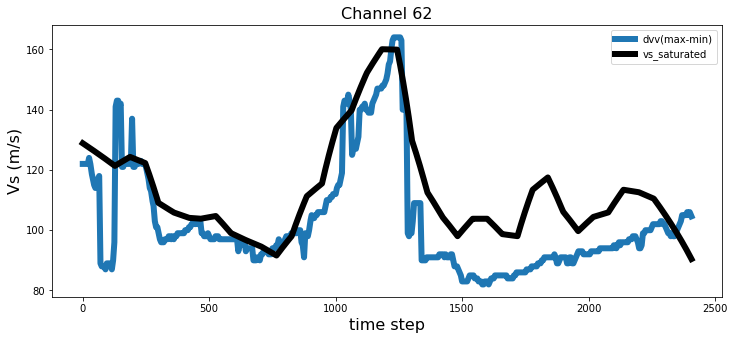

In [252]:
saturated_soil = litho(bulk_density, new_porosity, 5, new_f, moisture/100)
vp, vs, K, G, rho = saturated_soil.get_vp_vs()

plt.figure(figsize=(12, 5))
plt.plot(np.arange(len(dvv)), dvv*100, label='dvv(max-min)', lw=6)
plt.plot(np.arange(len(moisture)), vs, label='vs_saturated', color='k', lw=6)

plt.xlabel("time step", fontsize = 16)
plt.ylabel("Vs (m/s)", fontsize = 16)
plt.title("Channel 62", fontsize = 16)
plt.legend()